<a href="https://colab.research.google.com/github/BKousha/FloorPlanSegmentation/blob/main/inference_rooms_hallway_V1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'
'Copy of Predictive Maintenance Checklist.gdoc'
 FloorPlan_samples
 model_best_val_loss_var.pkl
 Processed_Floor_Plans
 ShotBot
'SNN_soft shadow network for image compositing.pdf'
 test.txt


In [2]:
# Define the class mapping for merging
class_names = {
    0: "background",
    1: "room",
    2: "hallway",
    3: "kitchen",
    4: "columns",
    5: "mep",
    6: "windows",
    7: "doors",
    8: "glass_doors",
    9: "bathrooms",
    10: "elevators",
    11: "elevator_doors",
    12: "stairs",
    13: "storage",
    14: "electrical"
}


In [3]:
import tensorflow as tf
#from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [12]:
# https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
# def dice_coe(output, target, axis = None, smooth=1e-10):
#     output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
#     target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
#     inse = tf.reduce_sum(output * target, axis=axis)
#     l = tf.reduce_sum(output, axis=axis)
#     r = tf.reduce_sum(target, axis=axis)

#     dice = (2. * inse + smooth) / (l + r + smooth)
#     dice = tf.reduce_mean(dice, name='dice_coe')
#     return dice

class FixedDropout(tf.keras.layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

In [5]:
tf.keras.backend.set_image_data_format('channels_last')
best_model_1_path=f'/content/drive/MyDrive/Processed_Floor_Plans/smaller_images/best_model_rooms_512_192_efb0_v1.h5'
#best_model_2_path=f'/content/drive/MyDrive/Processed_Floor_Plans/smaller_images/best_model_doors_512_256_efb0.h5'
#best_model_2_path=f'/content/drive/MyDrive/Processed_Floor_Plans/smaller_images/best_model_doors_512_224_efb2.h5'

In [13]:
best_model_1 = tf.keras.models.load_model(best_model_1_path, custom_objects={'FixedDropout':FixedDropout})#"dice_coe": dice_coe,
#best_model_2 = tf.keras.models.load_model(best_model_2_path, custom_objects={"dice_coe": dice_coe,'FixedDropout':FixedDropout})


In [14]:
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2
    """
    x, y,z = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)

    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx*ny,4)



In [15]:
def make_prediction(tf_model,image,patch_size,NEW_SIZE,overlap):
  slices=make_grid(image.shape,window=patch_size,min_overlap=overlap)
  image_patches = []
  mask_patches = []
  slices=make_grid(image.shape,window=patch_size,min_overlap=overlap)
  print(f'number of slices: {len(slices)}')
  for i,(x1,x2,y1,y2) in enumerate(slices):
    try:
          image_patch = image[x1:x2,y1:y2]
          image_patch= cv2.resize(image_patch, (NEW_SIZE, NEW_SIZE),interpolation = cv2.INTER_AREA)
          image_patches.append(image_patch)
    except:
          print(image_path,i)
          pass

  image_patches=np.concatenate( image_patches, axis=0 ).reshape(-1,NEW_SIZE,NEW_SIZE,3)

  flipped_image_lr = np.fliplr(image_patches)
  flipped_image_ud = np.flipud(image_patches)

  predicted_masks            = tf_model.predict(image_patches/255.)
  predicted_masks_flipped_lr = tf_model.predict(flipped_image_lr/255.)
  predicted_masks_flipped_ud = tf_model.predict(flipped_image_ud/255.)

  predicted_masks_flipped_lr_r= np.fliplr(predicted_masks_flipped_lr)
  predicted_masks_flipped_ud_r= np.flipud(predicted_masks_flipped_ud)



  pred_image=np.zeros((image.shape[0],image.shape[1])).astype(np.float32)
  n_pred=np.zeros((image.shape[0],image.shape[1]))
  predicted_masks_all=(predicted_masks+predicted_masks_flipped_lr_r+predicted_masks_flipped_ud_r)/3
  for i,(x1,x2,y1,y2) in enumerate(slices):
    tmp= cv2.resize(predicted_masks_all[i]*255, (y2-y1,x2-x1),interpolation = cv2.INTER_AREA)
    pred_image[x1:x2,y1:y2]=pred_image[x1:x2,y1:y2]+tmp
    n_pred[x1:x2,y1:y2]=n_pred[x1:x2,y1:y2]+1

  pred_image_final=(pred_image/n_pred)/255
  #pred_image_final[pred_image_final>cutoff]=1
  #pred_image_final[pred_image_final<cutoff]=0
  return pred_image_final

def make_bin(pred_prob,cutoff=0.2):
  pred=pred_prob.copy()
  pred[pred>cutoff]=1
  pred[pred<cutoff]=0
  return pred.astype(np.uint8)


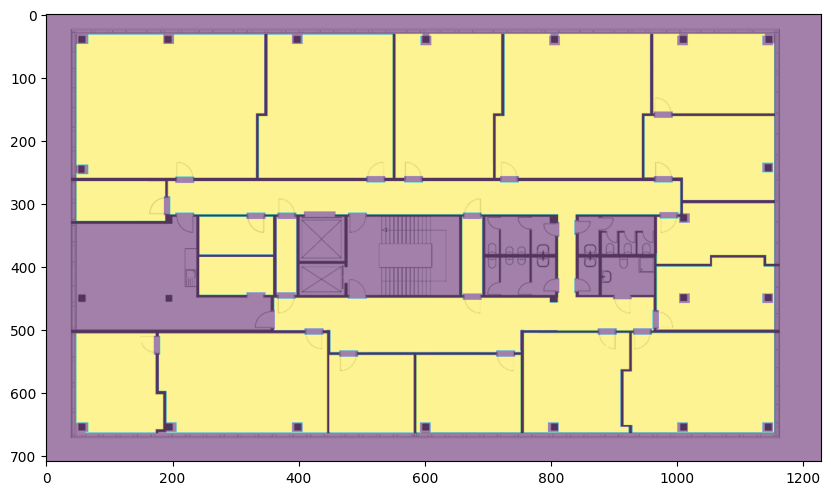

In [38]:


filename='3.png'
image_path='/content/drive/MyDrive/Processed_Floor_Plans/FP_raw/'+filename
image = cv2.imread(image_path)

imask=True
if imask:
  mask_path='/content/drive/MyDrive/Processed_Floor_Plans/FP_processed/Category/'+filename
  Number_Category=15
  mask_category_list=[1,2]
  mask  = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
  mask_cat = np.round(mask.astype(np.float64) * Number_Category / 255.0)
  mask_cat = np.where(np.isin(mask_cat, mask_category_list), 1, 0).astype(np.uint8)


fig, ax = plt.subplots(1, figsize=(10, 15))
ax.imshow(image)
ax.imshow(mask_cat,alpha=0.5)
plt.show()


In [39]:

patch_size = 512
NEW_SIZE= 192
scale=patch_size//NEW_SIZE
overlap = 300


pred_prob_1=make_prediction(best_model_1,image=image,patch_size=patch_size,NEW_SIZE=NEW_SIZE,overlap=overlap)

#NEW_SIZE= 224
#pred_prob_2=make_prediction(best_model_2,image=image,patch_size=patch_size,NEW_SIZE=NEW_SIZE,overlap=overlap)


number of slices: 24
1/1 [==============================] - 3s 3s/step


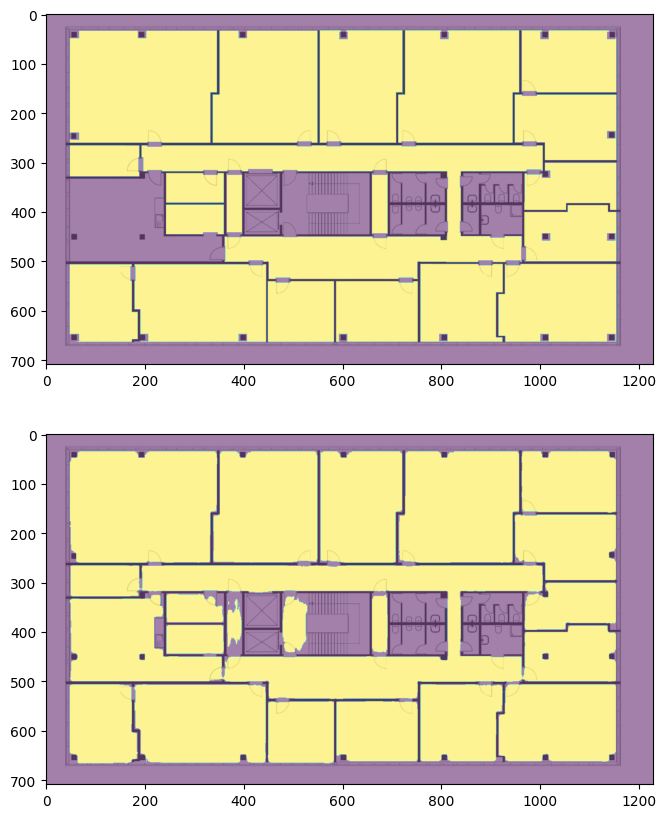

In [41]:
pred_image_final_1=make_bin(pred_prob_1,cutoff=0.5)
#pred_image_final_2=make_bin(pred_prob_2,cutoff=0.15)

#pred_prob_12=(pred_prob_1+pred_prob_2)/2
#pred_image_final_12=make_bin(pred_prob_12,cutoff=0.15)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].imshow(image)
axes[0].imshow(mask_cat,alpha=0.5)
axes[1].imshow(image)
axes[1].imshow(pred_image_final_1,alpha=0.5)
#axes[2].imshow(image)
#axes[2].imshow(pred_image_final_2,alpha=0.5)
#axes[3].imshow(image)
#axes[3].imshow(pred_image_final_12,alpha=0.5)

plt.show()


pred_image_final_1 = np.expand_dims(pred_image_final_1, axis=-1)
#pred_image_final_2 = np.expand_dims(pred_image_final_2, axis=-1)
#pred_image_final_12 = np.expand_dims(pred_image_final_12, axis=-1)

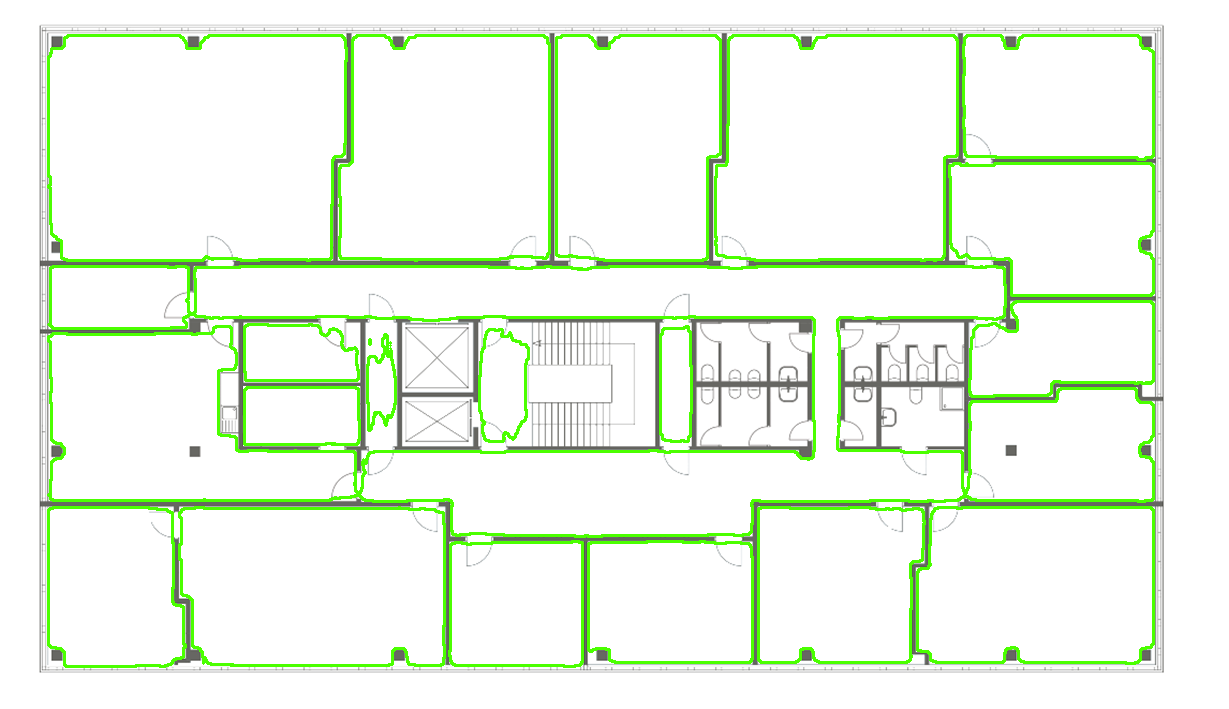

0

In [42]:
from google.colab.patches import cv2_imshow

def show_image(image):
    cv2_imshow(image)
    c = cv2.waitKey()
    if c >= 0 : return -1
    return 0


#contours, hierarchy  = cv2.findContours(pred_image_final_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours, hierarchy  = cv2.findContours(pred_image_final_1*255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
res_img = cv2.drawContours(image, contours, -1, (0, 255, 75), 2)
show_image(res_img)

# contours, hierarchy  = cv2.findContours(pred_image_final_2*255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# res_img = cv2.drawContours(image, contours, -1, (0, 255, 75), 2)
# show_image(res_img)


# contours, hierarchy  = cv2.findContours(pred_image_final_12*255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# res_img = cv2.drawContours(image, contours, -1, (0, 255, 75), 2)
# show_image(res_img)


